In [1]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import json
import cv2
import matplotlib.image
from glob import glob
import torch
from model_factory import get_model
import argparse
from model_factory import UNet

In [2]:
"""configurations"""
device = torch.device("cuda:0")
version = "baseline_selection"
config_path = f"/root/autoencoder_denoiser/configs_{version}"
exp_dir = f'/root/autoencoder_denoiser/exps/results_{version}'

class Test():
    def __init__(self, model_name, 
                    config_path = config_path,
                    exp_dir = exp_dir) -> None:
        self.dilation = False
        self.resize = True
        self.config = None
        name = model_name
        self.name = name

        f = open(f'{config_path}/'+ name + '.json')
        self.config = json.load(f)
        experiment_path = f"{exp_dir}/{name}/" 
        print('load from: ', os.path.join(experiment_path, 'latest_model.pt'))
        state_dict = torch.load(os.path.join(experiment_path, 'latest_model.pt'))
        model = get_model(self.config)
        # try:
        model.load_state_dict(state_dict['model'])
        model = torch.nn.DataParallel(model)
        # except:
        #     model = torch.nn.DataParallel(model)
        #     model.load_state_dict(state_dict['model'])
            
        model.to(device)
        model.eval()
        self.model = model

        
# my_model_test = Test("t1_03")
# paper_1d_test = Test("paper_1d")




In [3]:
# dann_test = Test('dann')
# cdan_test = Test('cdan')
# cdan_e_test=  Test('cdan_e')
# enlarged_baseline_test = Test("baseline_enlarge_2")
match_hist_baseline_test = Test("match_hist")
# one_d_test= Test('paper_1d', config_path='/root/autoencoder_denoiser/configs')
# CE_loss = Test("CE_loss_old_dataset")

load from:  /root/autoencoder_denoiser/exps/results_baseline_selection/match_hist/latest_model.pt
model :UNet


In [4]:
from hsqc_dataset import *
from tqdm import tqdm
'''creating test dataloader of real noise'''
config = match_hist_baseline_test.config
batch = config["dataset"]['batch_size']
shuffle=config["dataset"]['shuffle']

test_loader = DataLoader(RealNoiseDataset_Byeol(config), batch_size=2, shuffle=False, num_workers=1)

criterion = torch.nn.MSELoss(reduction="sum")
clist = [(0,"darkblue"), (0.5,"white"), (1, "darkred")]
custom_HSQC_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("_",clist)
diff_clist = [(0,"green"), (0.5,"white"), (1, "red")]
custom_diff_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("_",diff_clist)



def test(*model_tests):
    for model_test in model_tests:
        displayed=0
        display_num = 0
        loss = 0
        plt.rcParams["figure.figsize"] = (20,10)
        with torch.no_grad():
            for iter, data in enumerate(tqdm(test_loader)):
                noise, raw = data
                if len(raw.shape)==3:   
                    raw, noise = raw.unsqueeze(1), noise.unsqueeze(1)
                raw, noise = raw.to(device).float(), noise.to(device).float()
                prediction = model_test.model.forward(noise)
                
                # find loss
                # prediction = prediction.type(torch.float32)
                ground_truth = raw
            
                # add adv loss !!!
                prediction = torch.clip(prediction,-1,1)

            # print(denoised_1.shape)
            # print(ground_truth.shape)
                loss += criterion(prediction,ground_truth )
            
            
            
                if displayed>10:
                    noise_pic , prediction_pic, raw_pic = noise[1],prediction[1], raw[1]
                    
                    # print("?")
                    # plt.clf()

                    ax = plt.subplot(2, 2, 1)
                    plt.tight_layout()
                    ax.set_title('original',fontsize=18)
                    # ax.axis('off')
                    plt.imshow(raw_pic[0].cpu(),cmap=custom_HSQC_cmap, vmax=1, vmin=-1)
                    plt.colorbar()
                    
                    ax = plt.subplot(2, 2, 2)
                    plt.tight_layout()
                    ax.set_title('noise',fontsize=18)
                    # ax.axis('off')
                    plt.imshow(noise_pic[0].cpu(),cmap=custom_HSQC_cmap, vmax=1, vmin=-1)
                    plt.colorbar()
                    
                    ax = plt.subplot(2, 2, 3)
                    plt.tight_layout()
                    ax.set_title('predicted',fontsize=18)
                    # ax.axis('off')
                    plt.imshow(prediction_pic[0].cpu(),cmap=custom_HSQC_cmap, vmax=1, vmin=-1)
                    plt.colorbar()
                    
                    ax = plt.subplot(2, 2, 4)
                    plt.tight_layout()
                    ax.set_title('difference', fontsize=18)
                    # ax.axis('off')
                    
                    # difference = prediction_pic[0].cpu()-raw_pic[0].cpu()
                    # difference = difference.float()/2 + 0.5
                    # print(difference)
                    difference = cv2.subtract(np.array(prediction_pic[0].cpu()), np.array(raw_pic[0].cpu()))
                    plt.imshow(difference, cmap = custom_diff_cmap, vmax=1, vmin=-1)

                    plt.colorbar()


                    # print(os.path.join(self._test_samples_path, f"sample_image{displayed}.png"))
                    # plt.savefig(os.path.join(self._test_samples_path, f"sample_image{displayed}.png"))
                    plt.figure()
                displayed = displayed+1
            
                    
            loss /= len(test_loader.dataset)    
            print("test loader size:" , len(test_loader.dataset))
            print(f"loss of model: {model_test.name} is {loss}")

    
    

100%|██████████| 30/30 [00:08<00:00,  3.51it/s]


test loader size: 60
loss of model: match_hist is 38.457340240478516


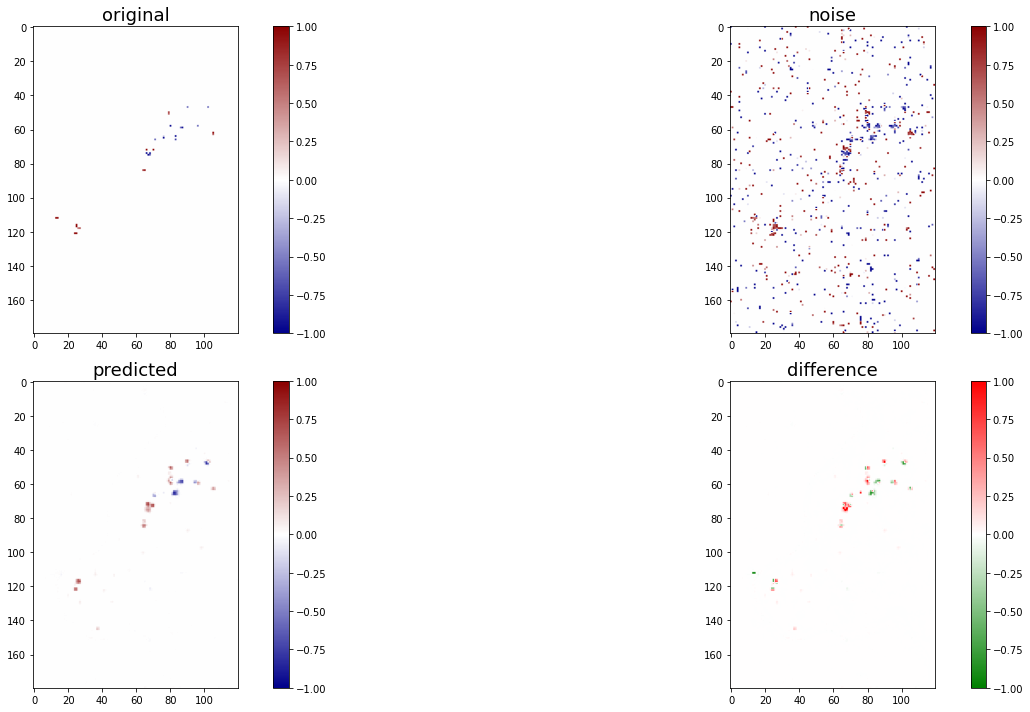

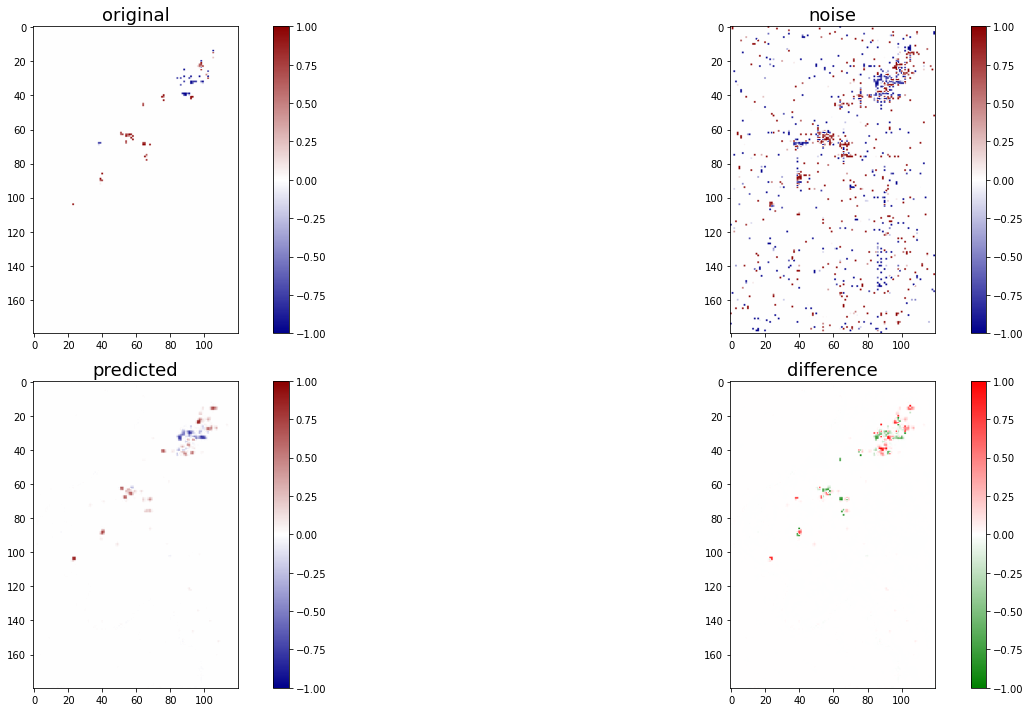

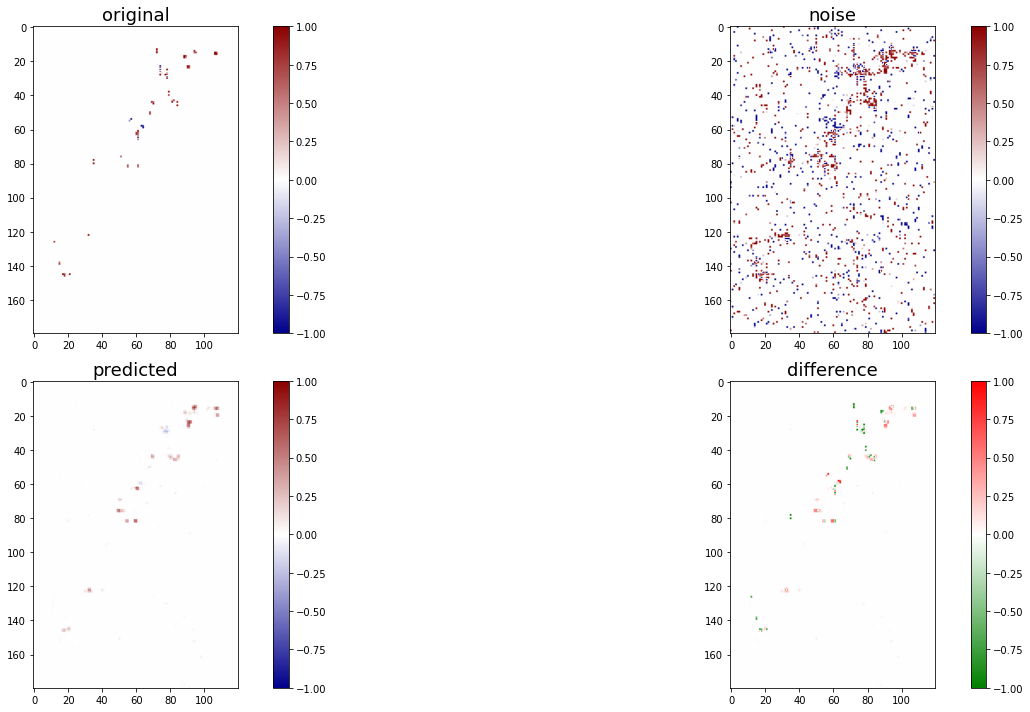

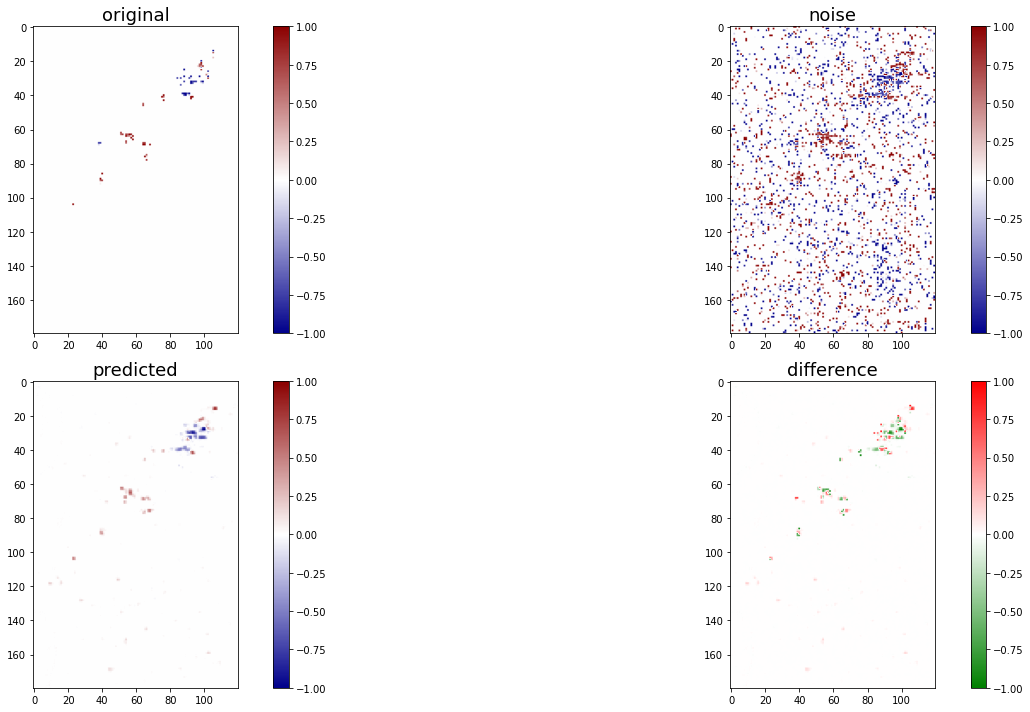

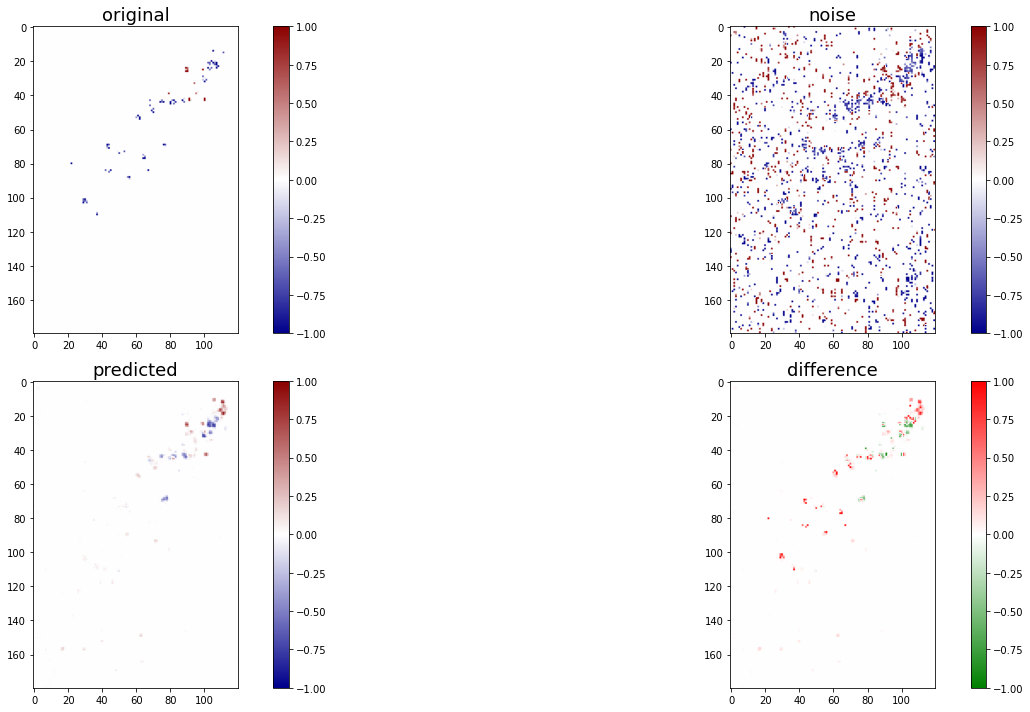

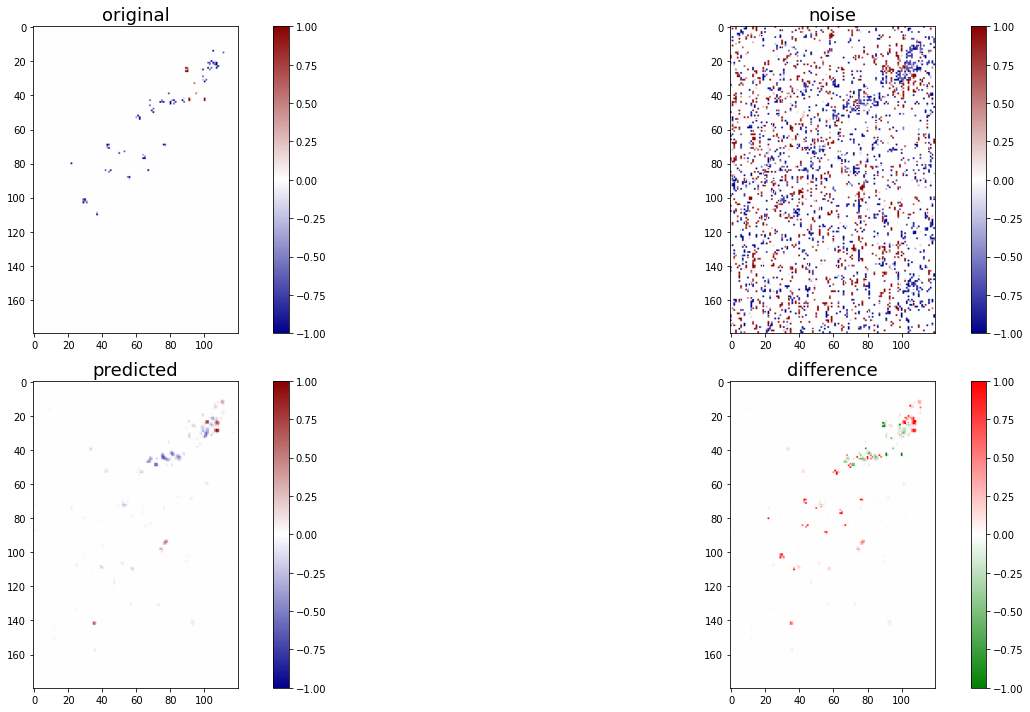

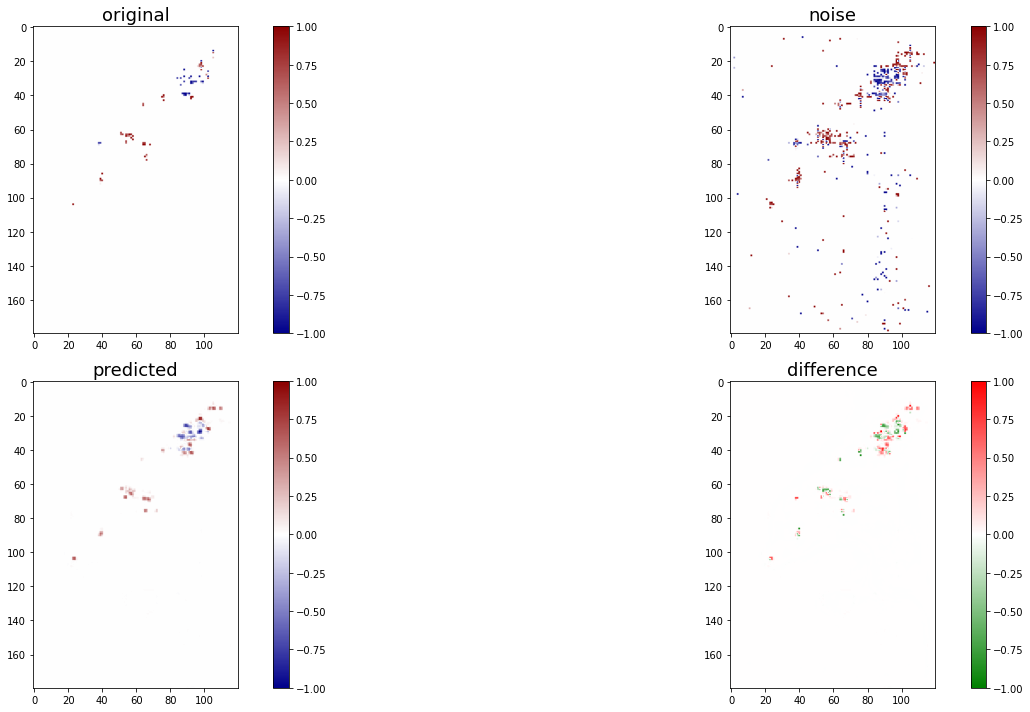

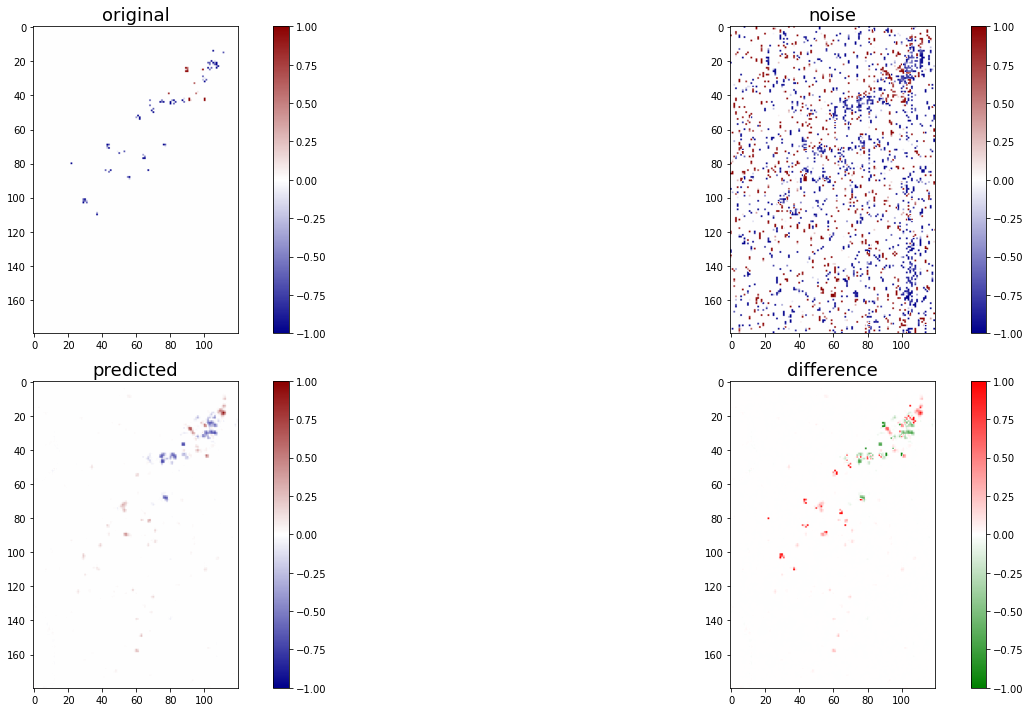

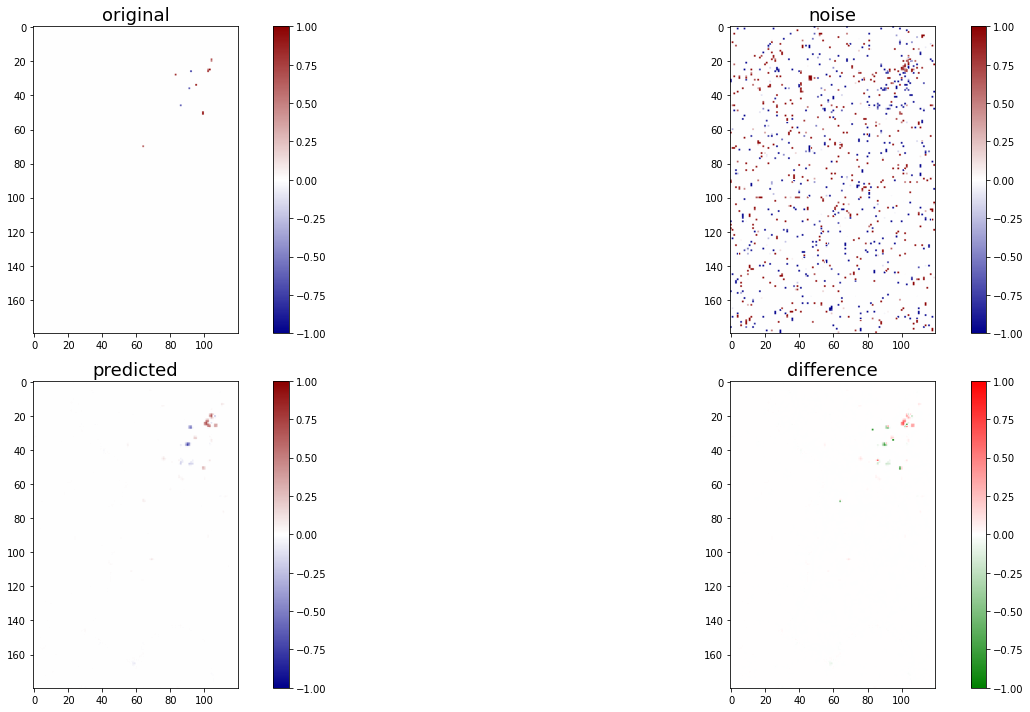

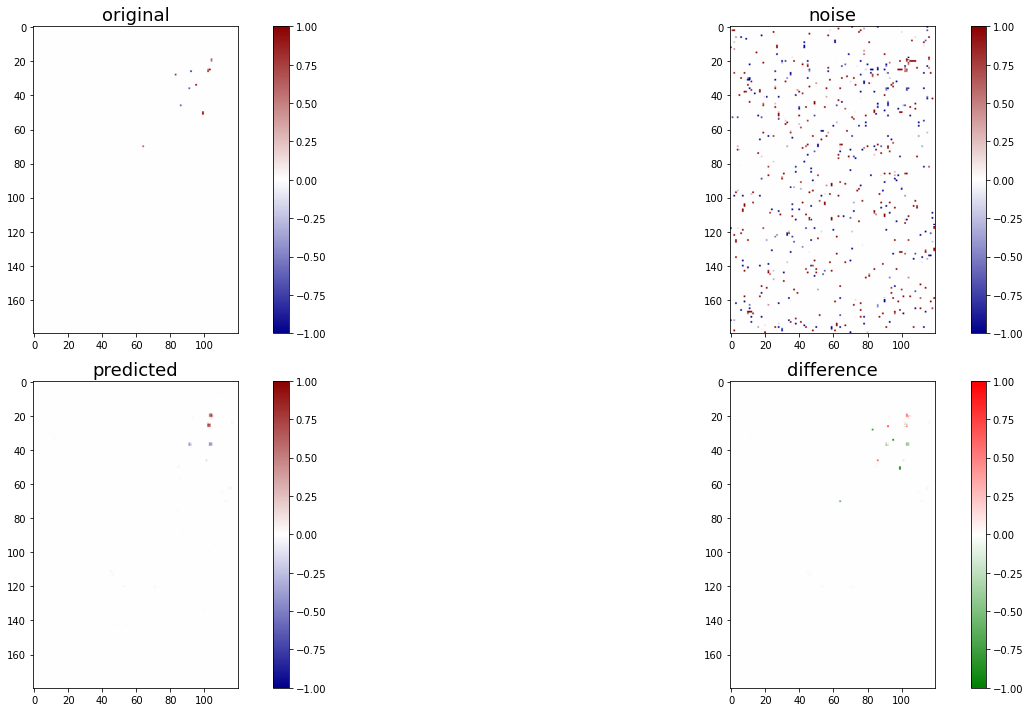

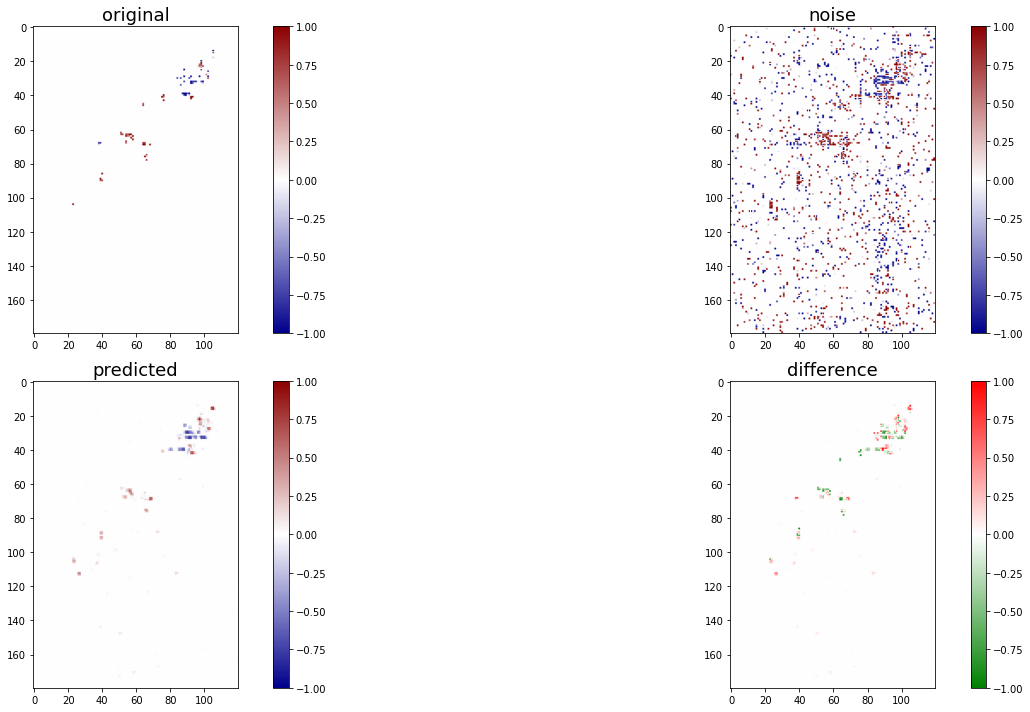

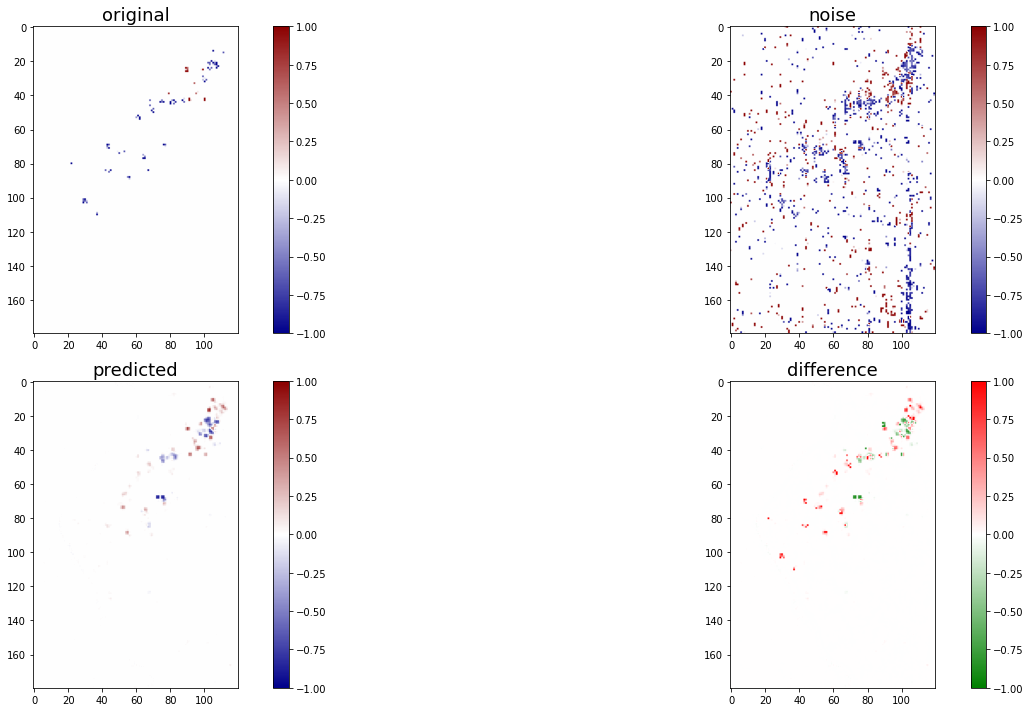

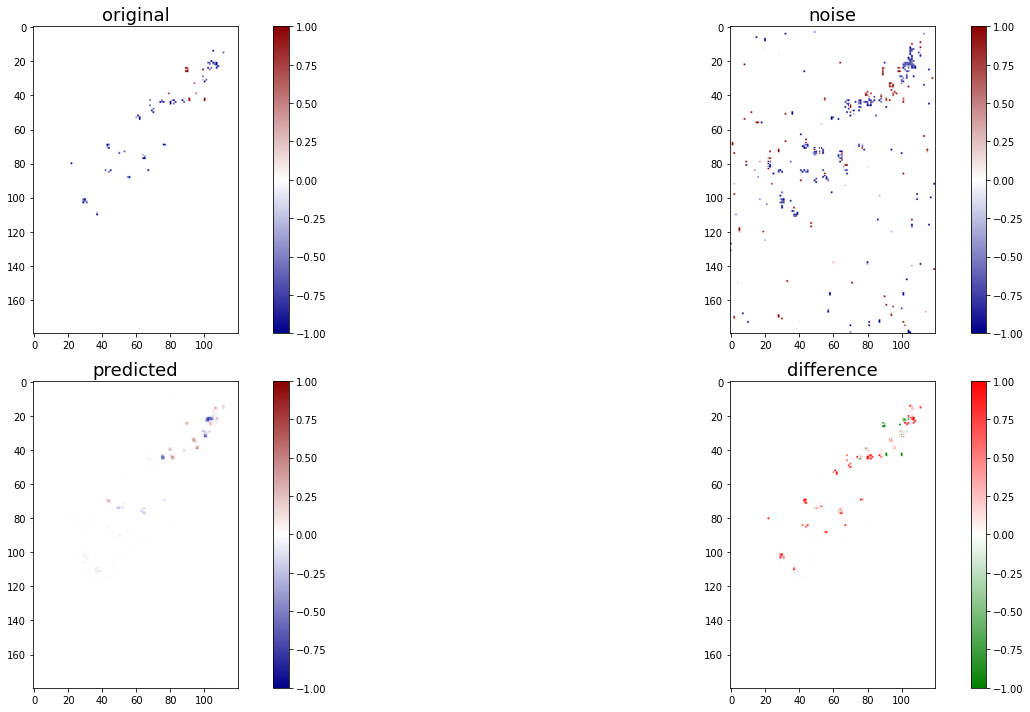

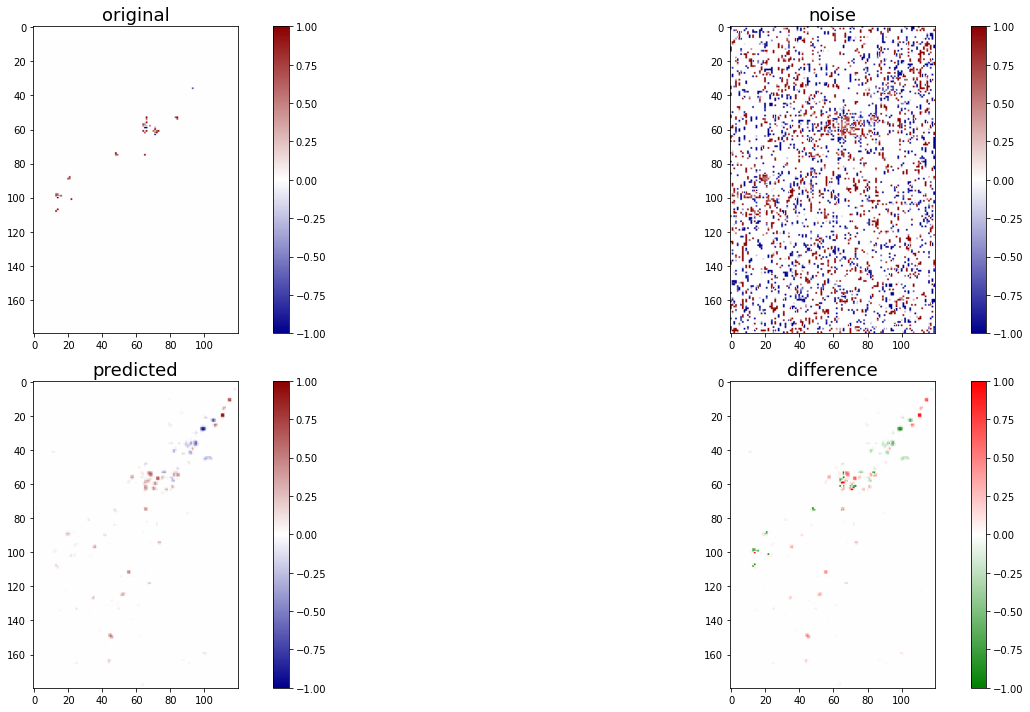

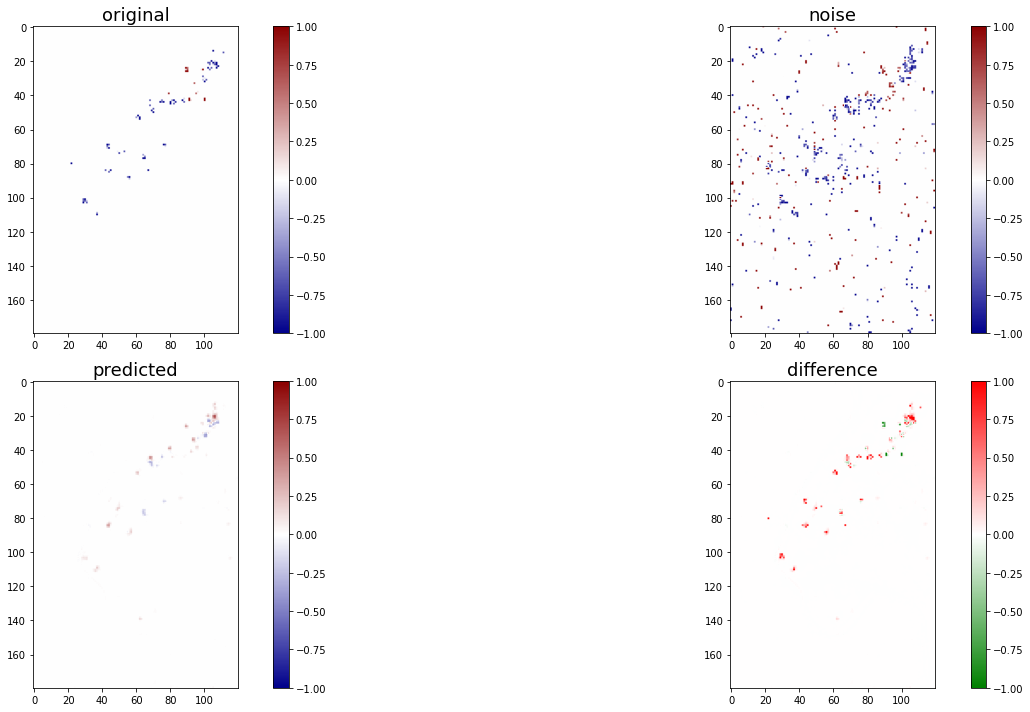

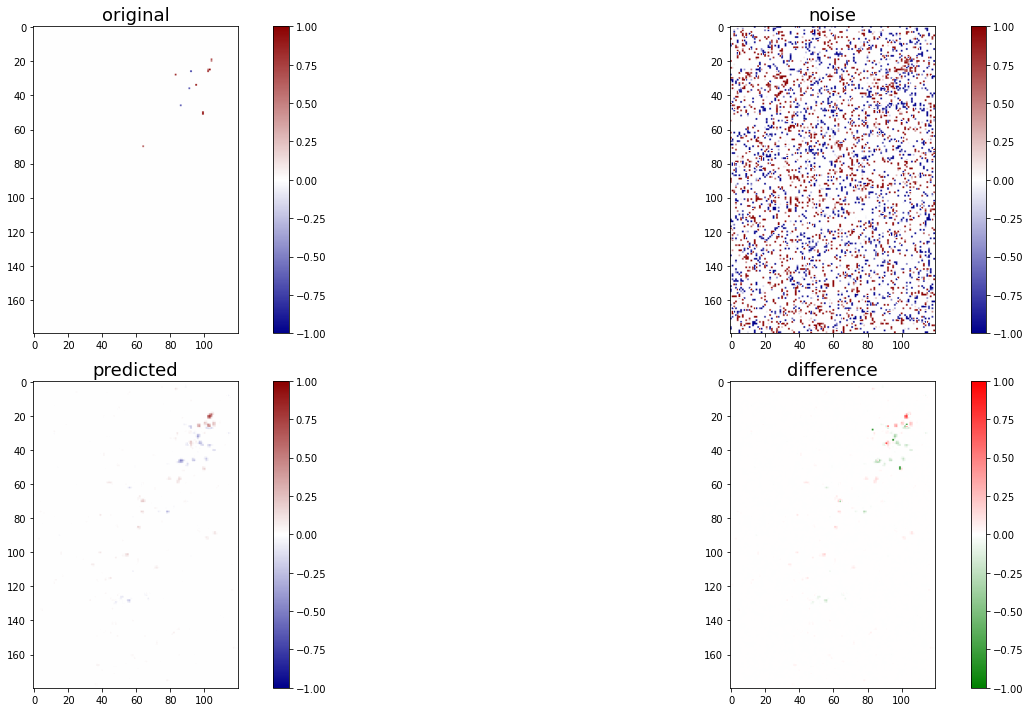

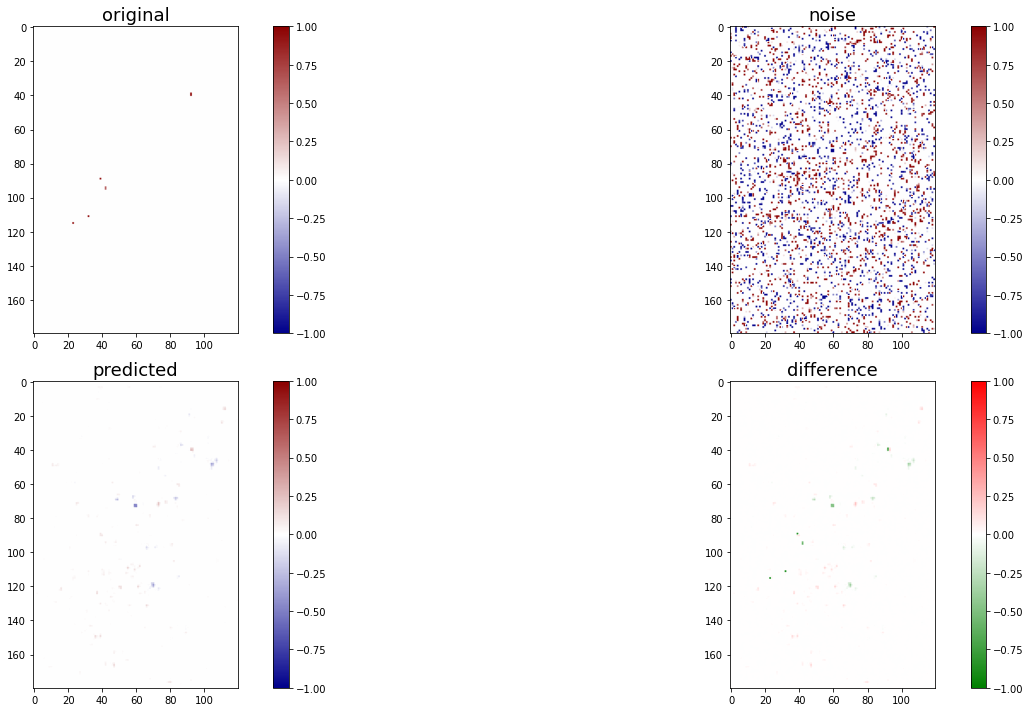

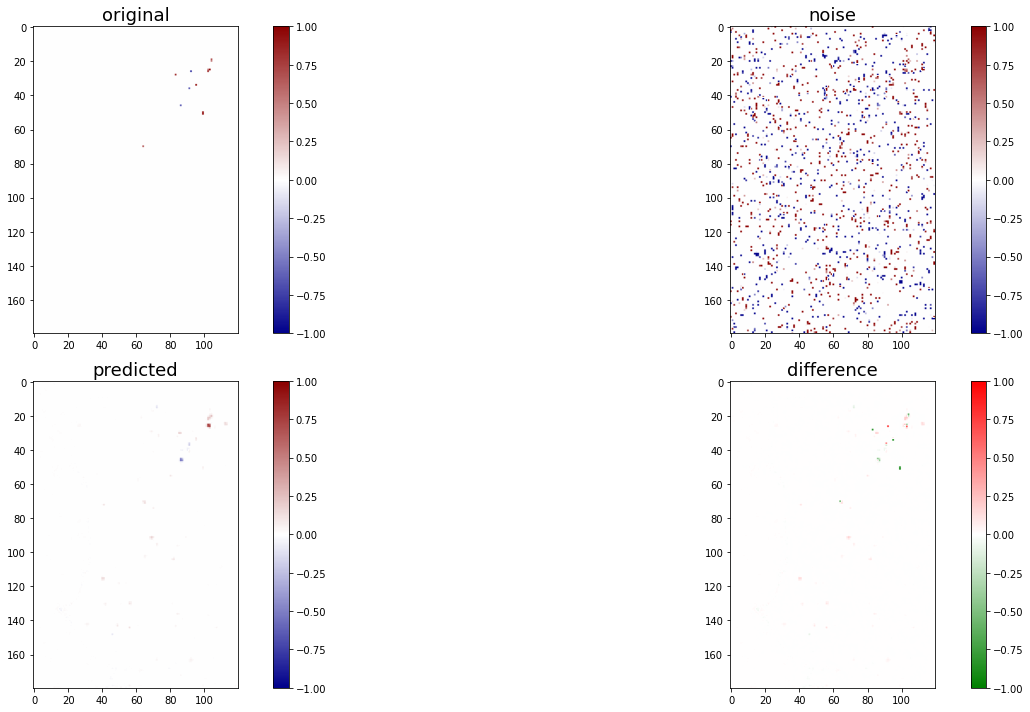

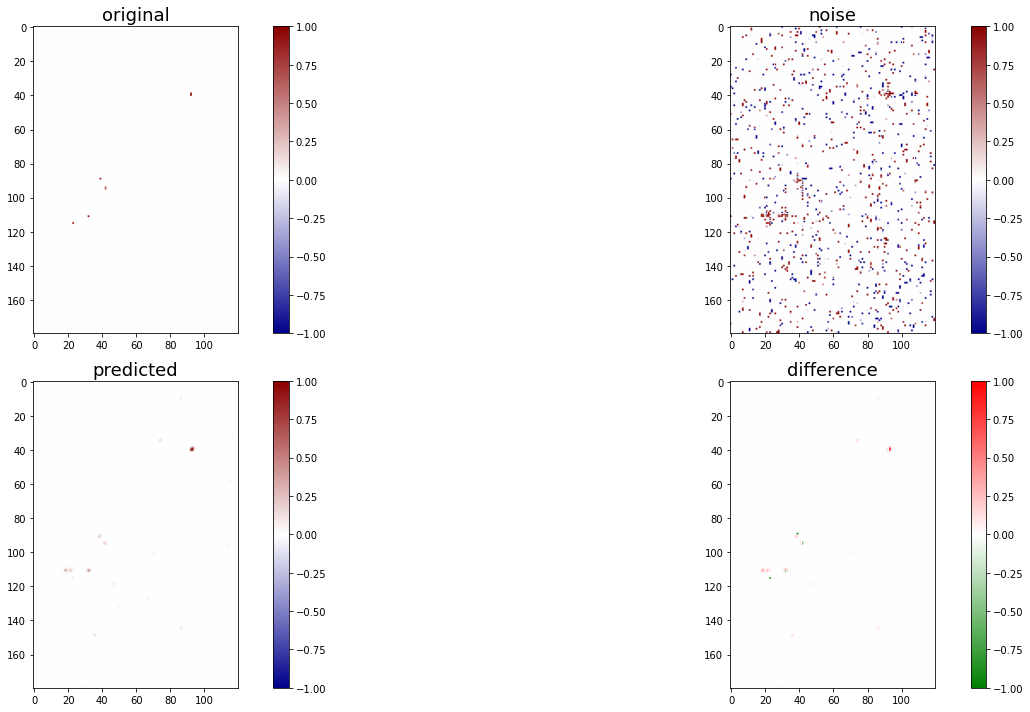

<Figure size 1440x720 with 0 Axes>

In [6]:
plt.rcParams["figure.figsize"] = (20,16)

test(match_hist_baseline_test )



100%|██████████| 30/30 [00:09<00:00,  3.16it/s]


test loader size: 60
loss of model: match_hist is 41.271114349365234


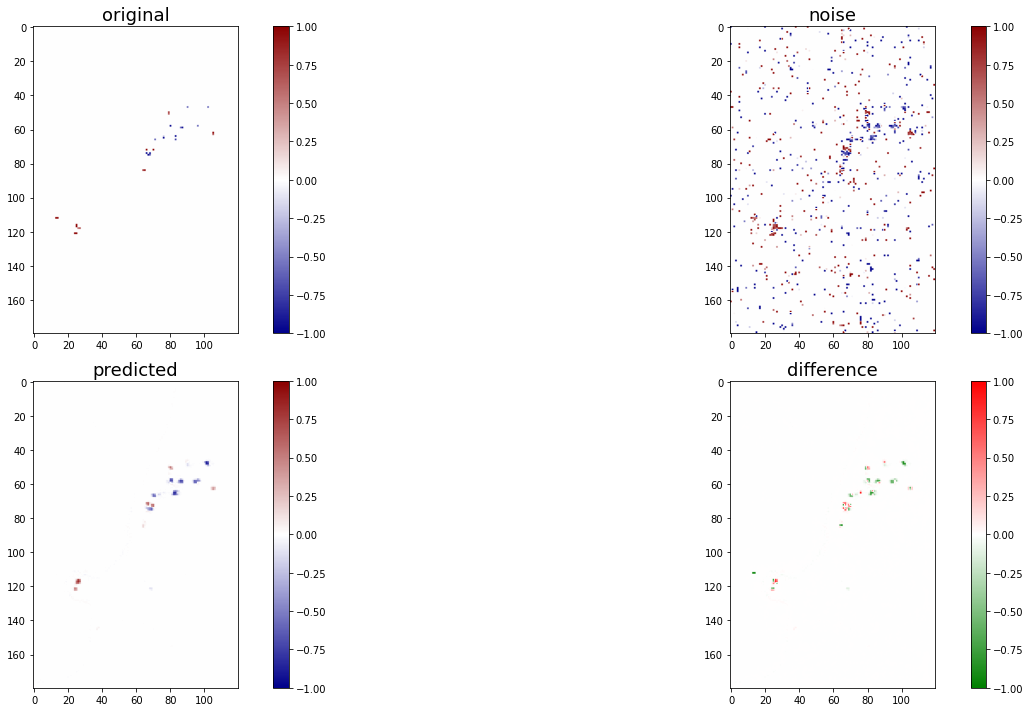

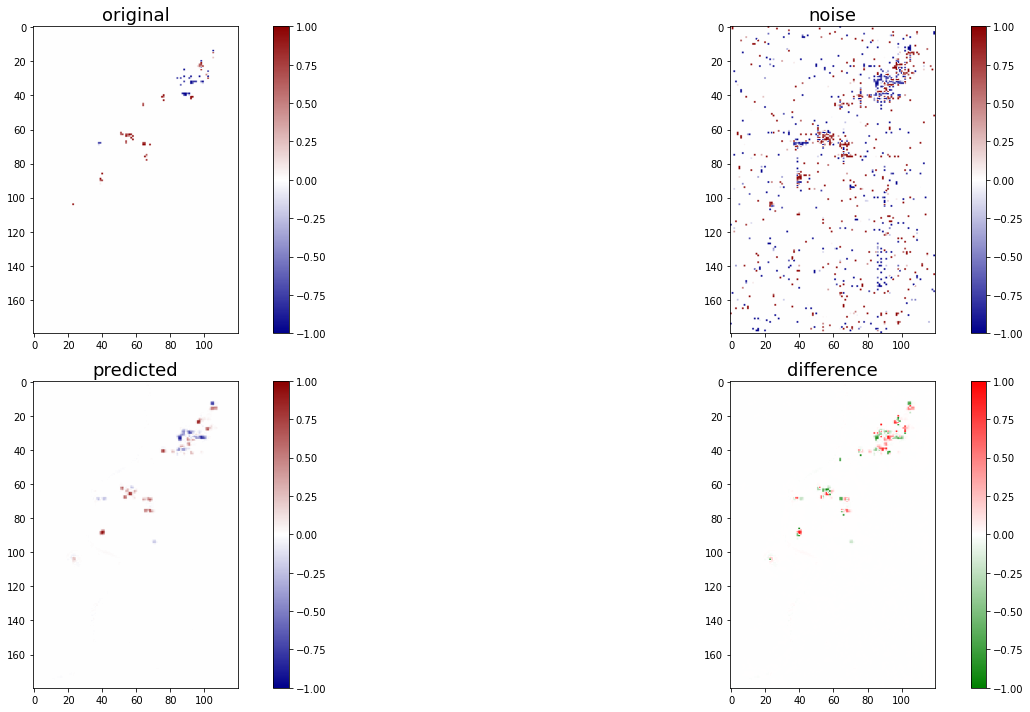

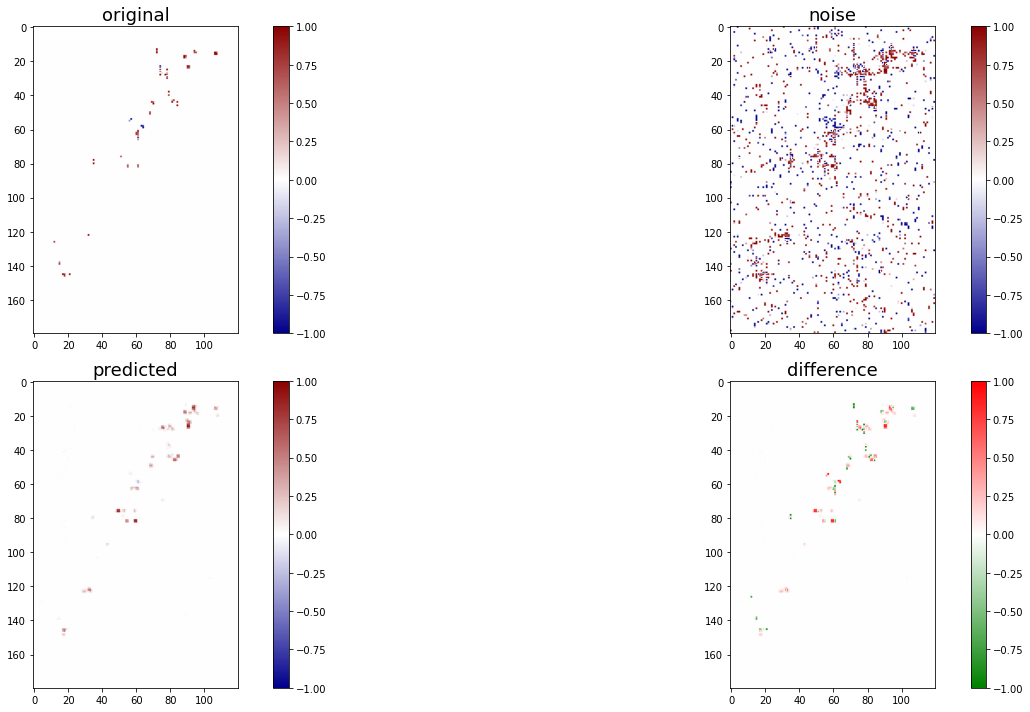

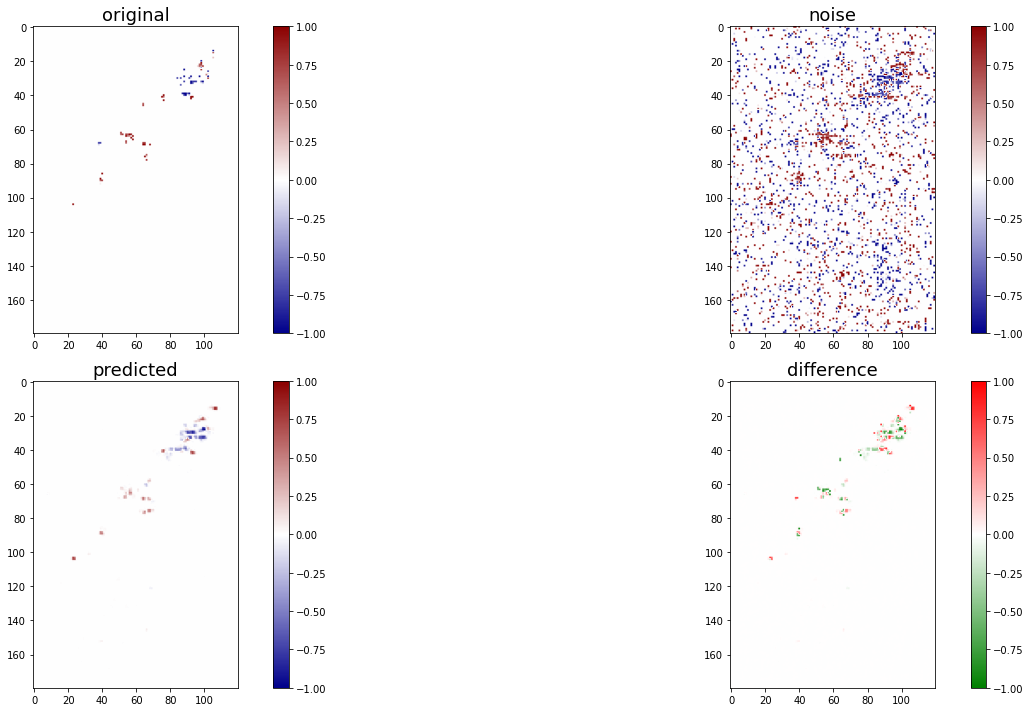

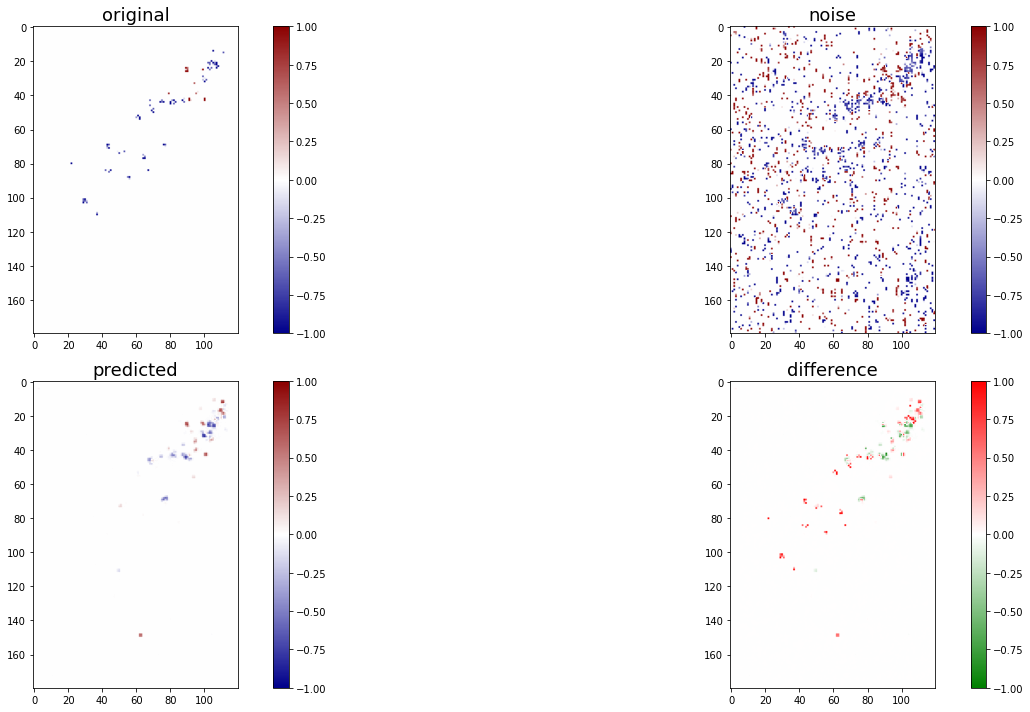

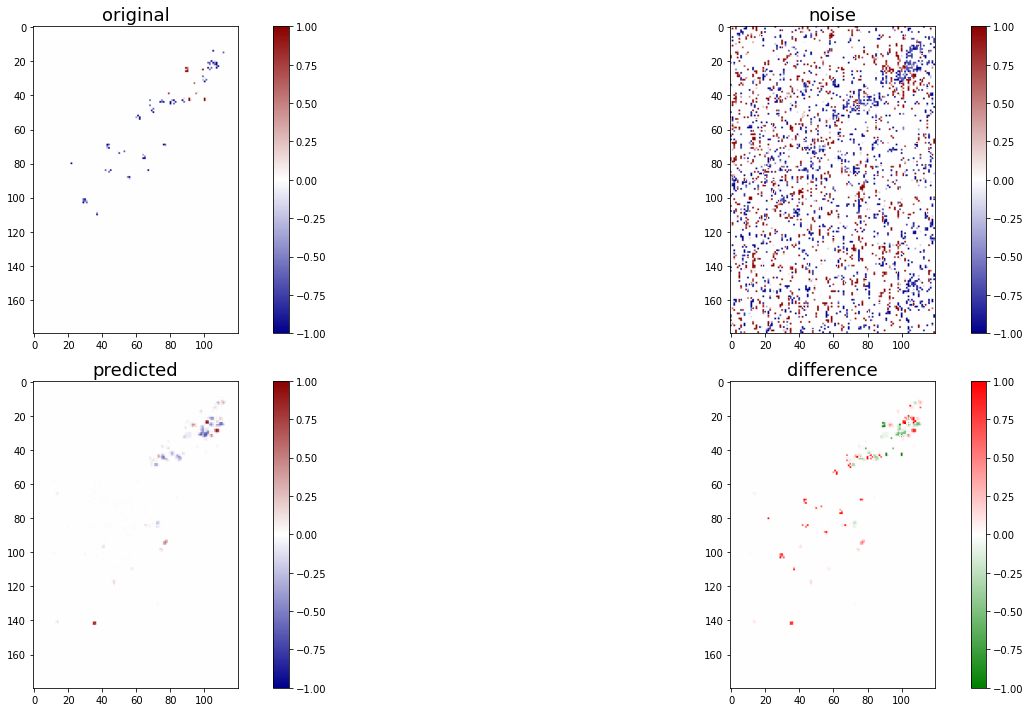

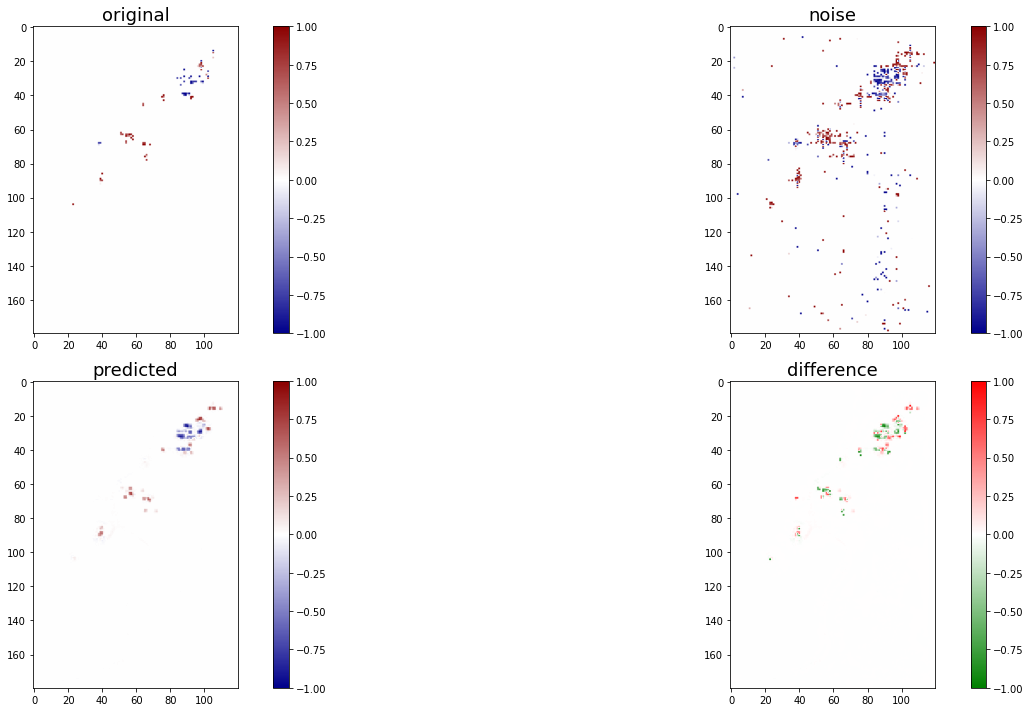

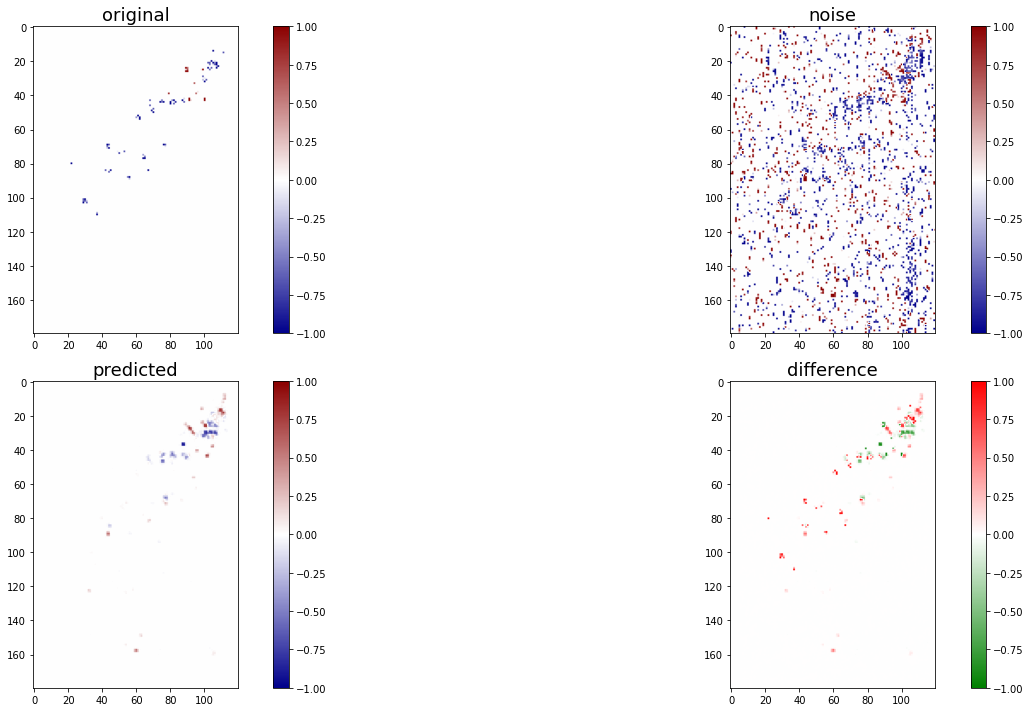

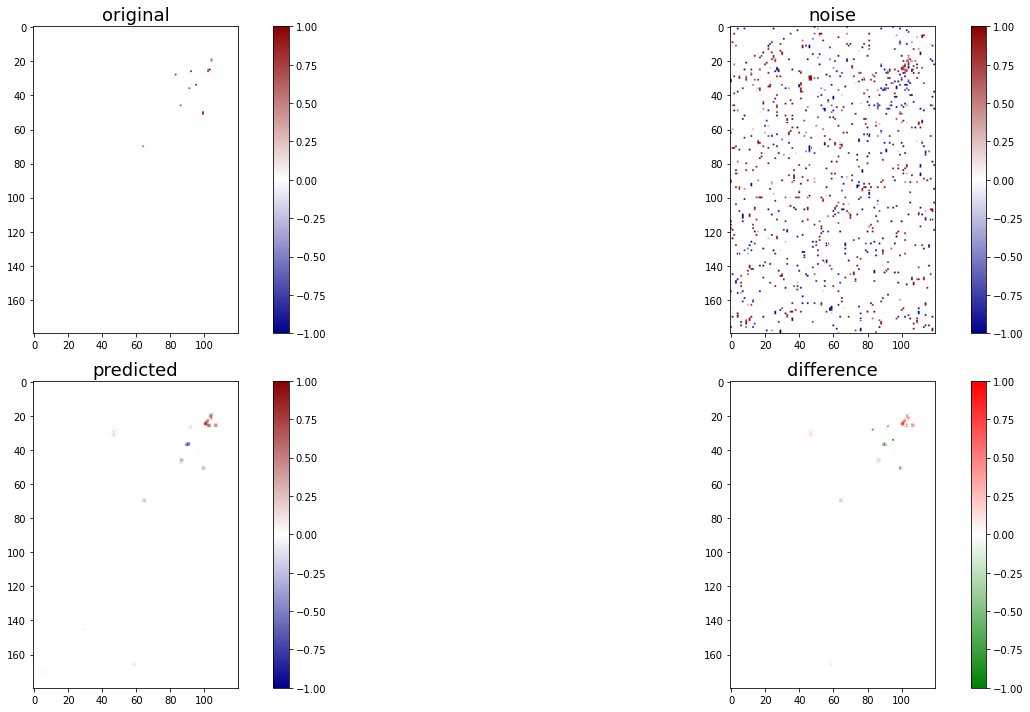

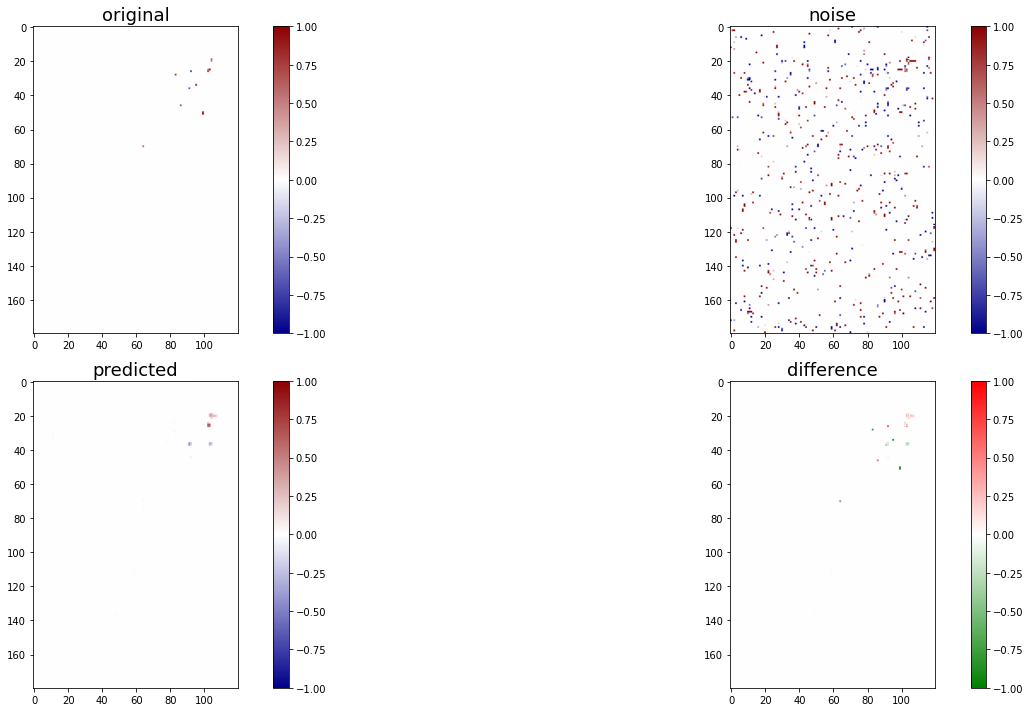

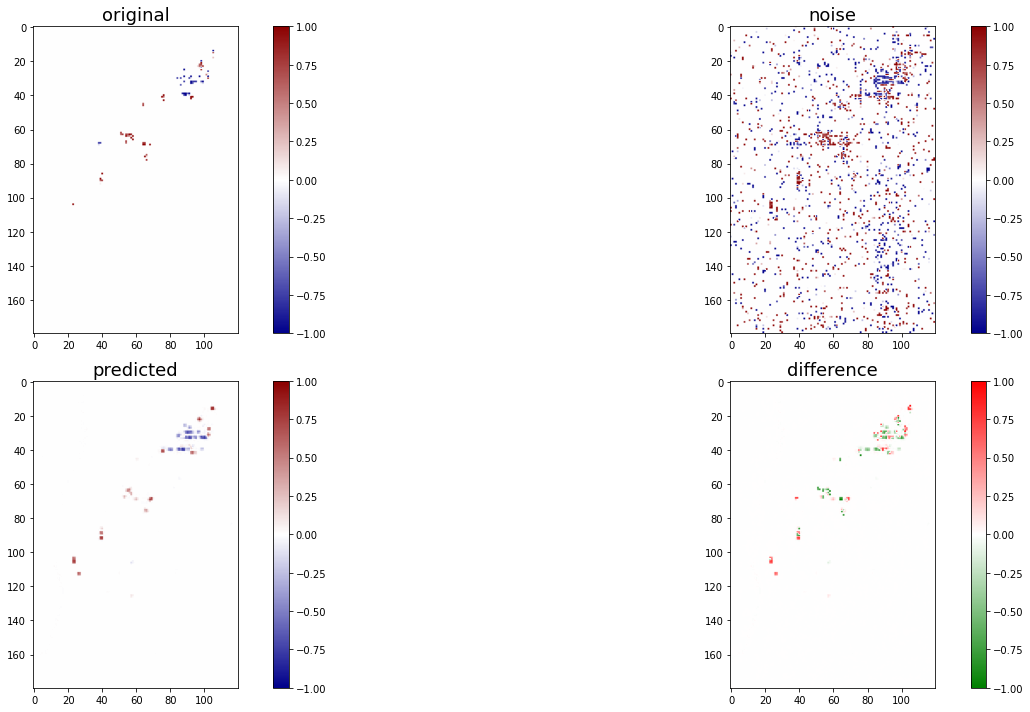

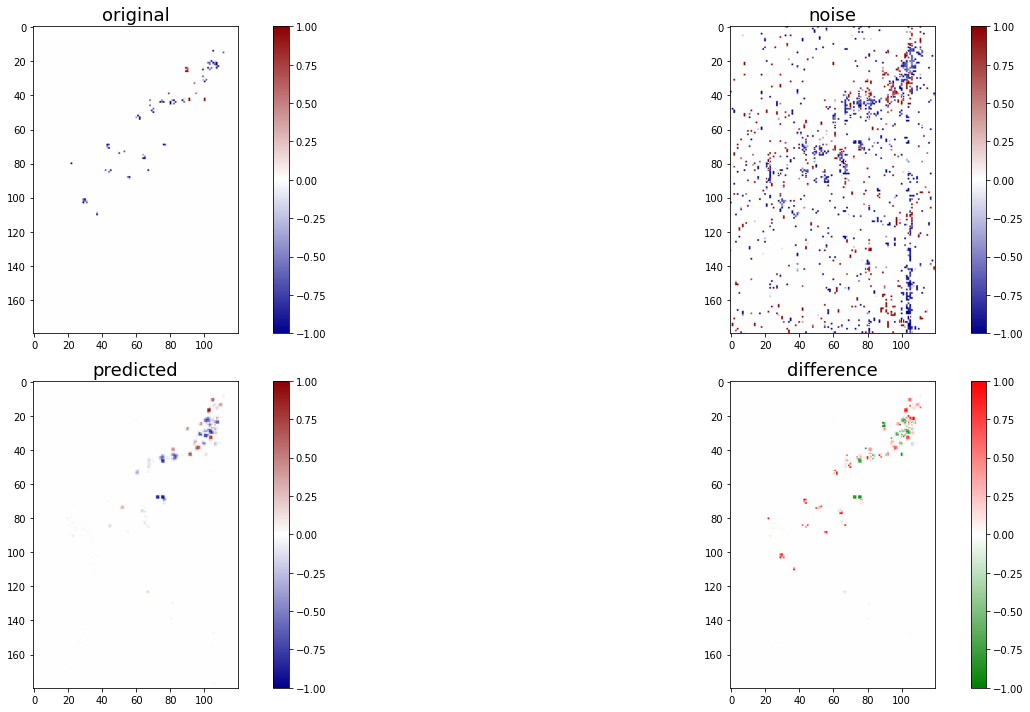

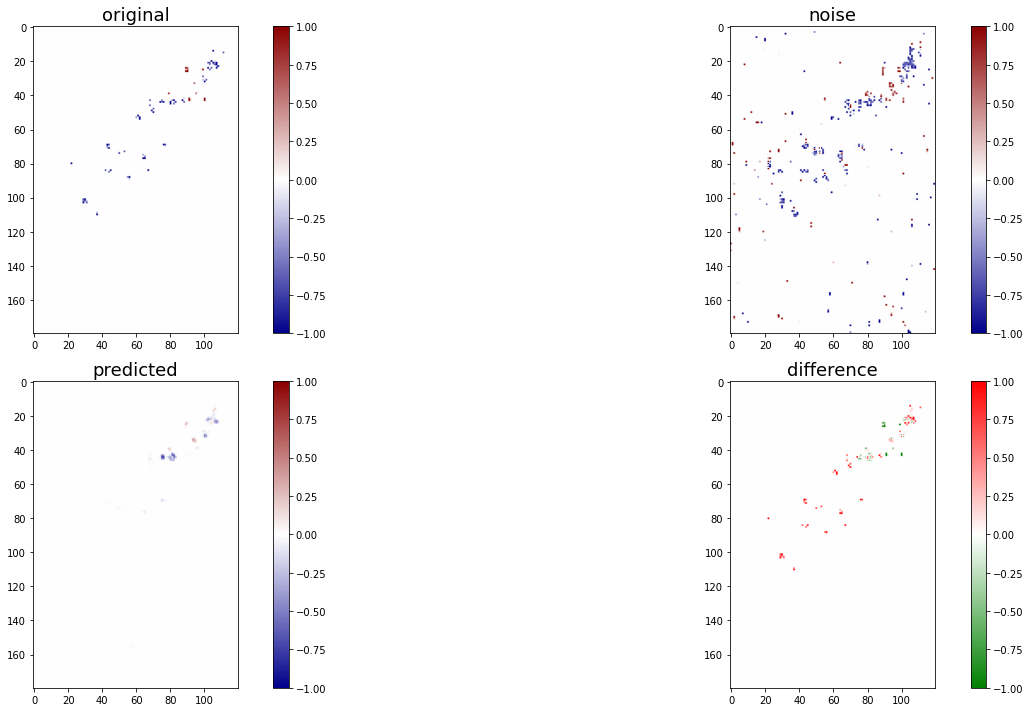

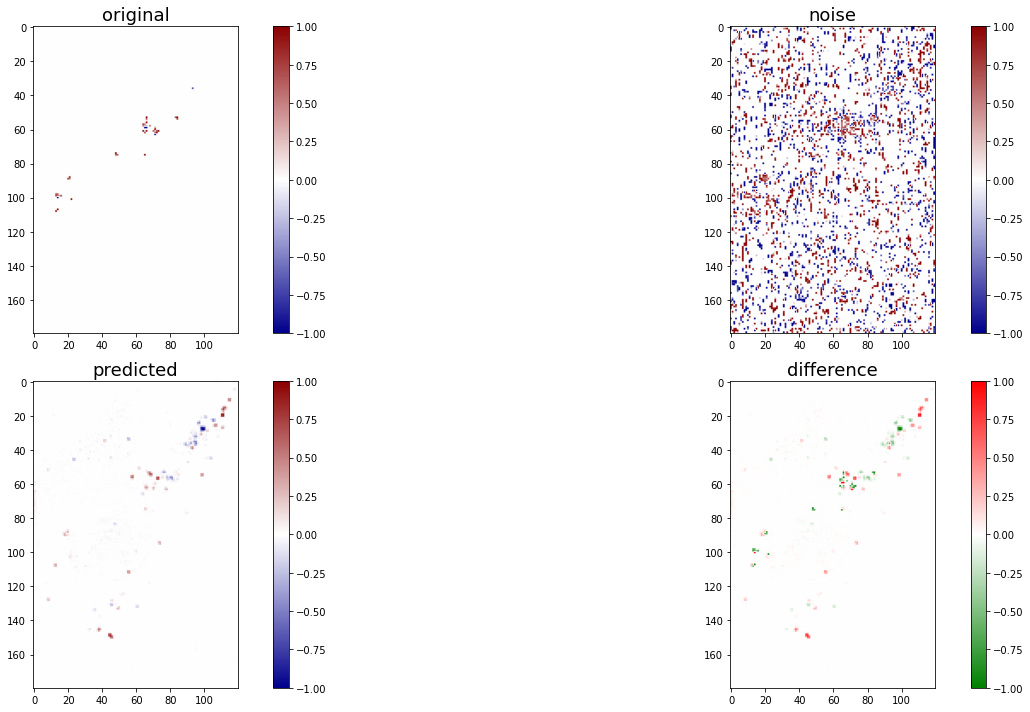

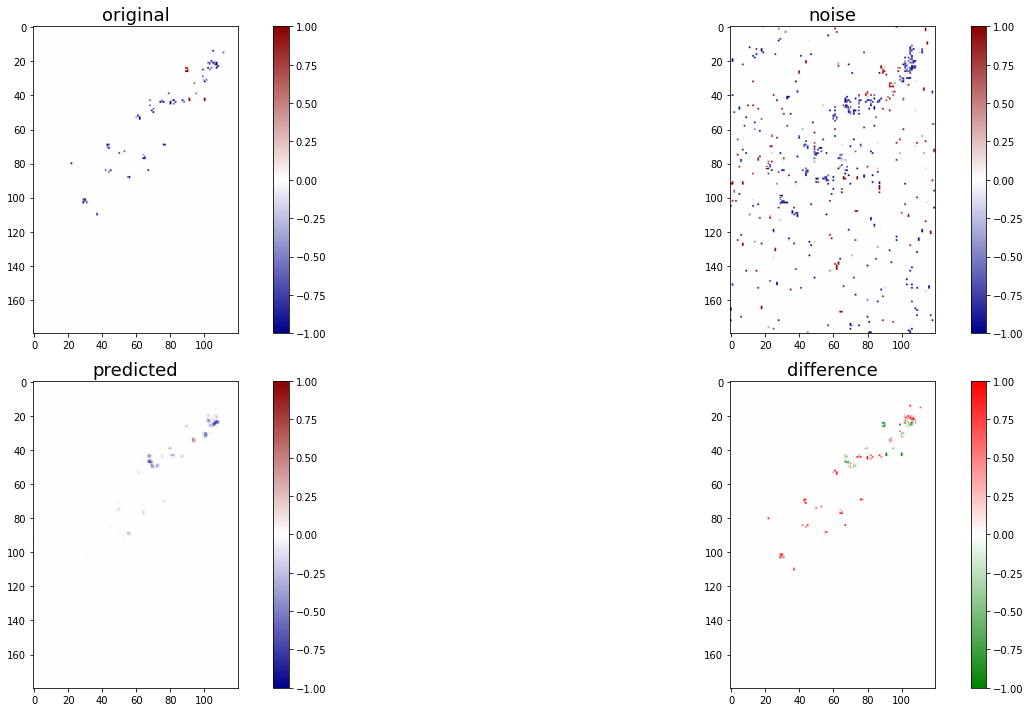

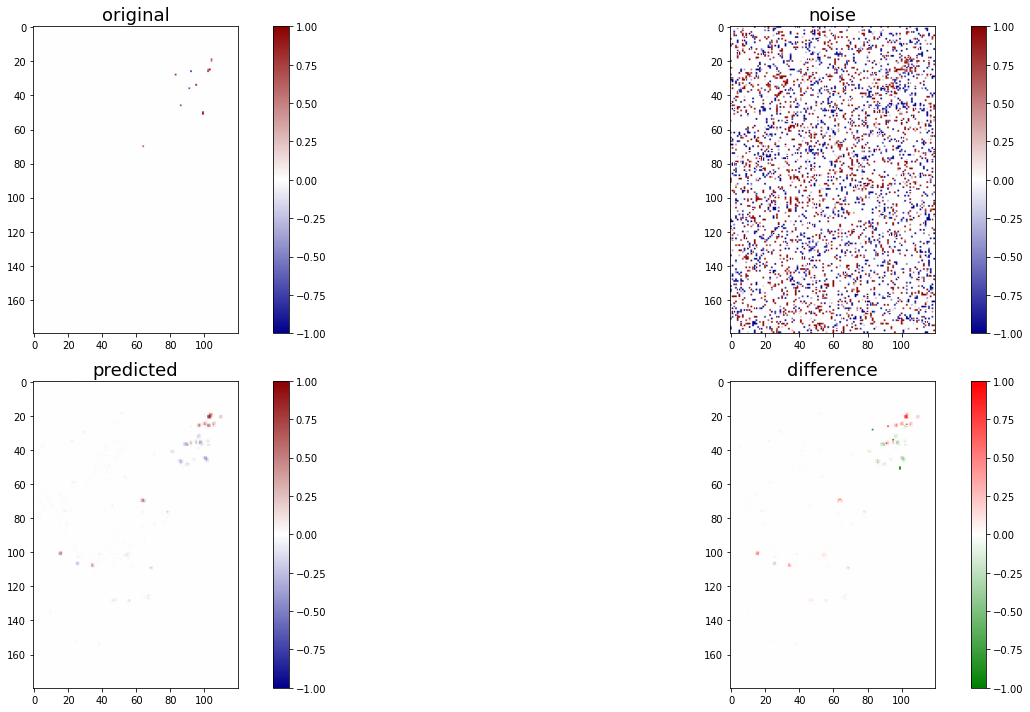

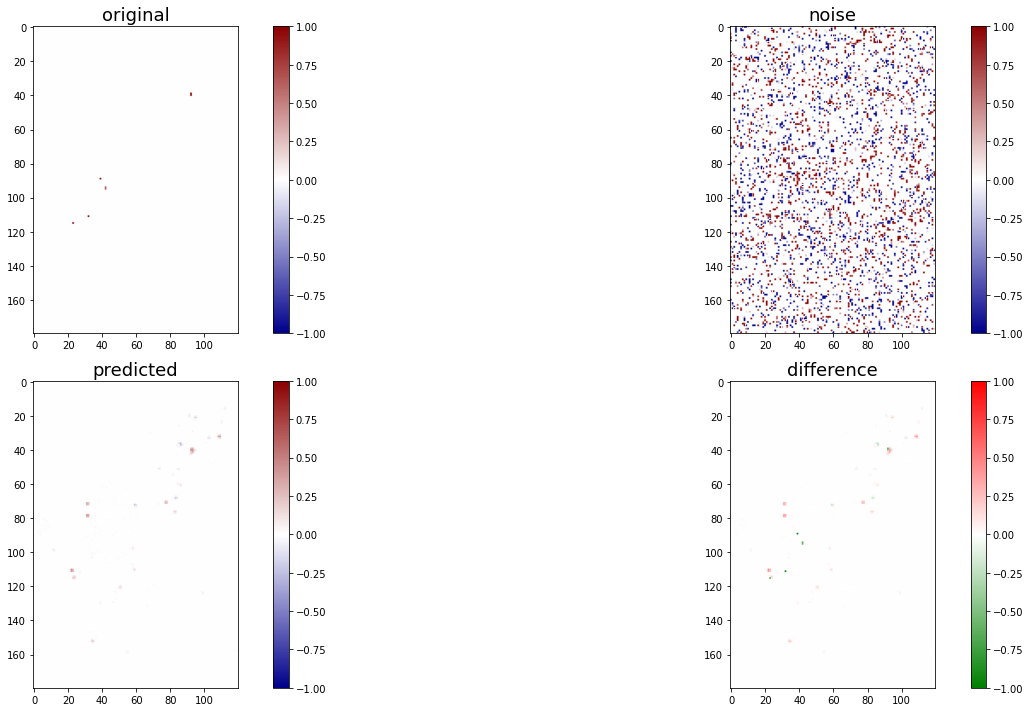

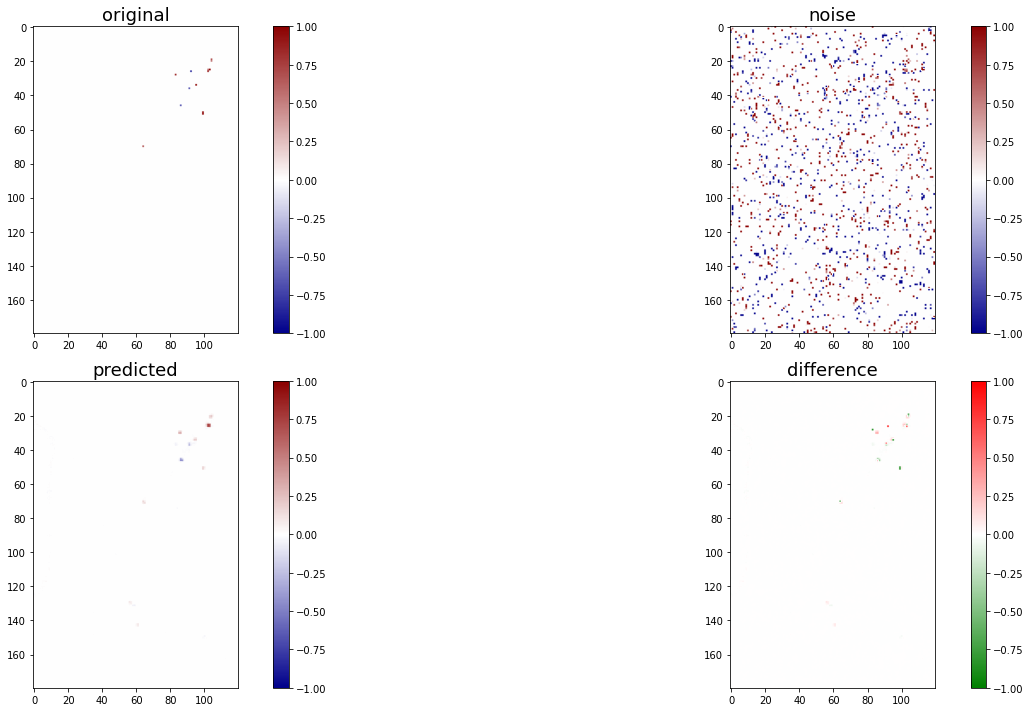

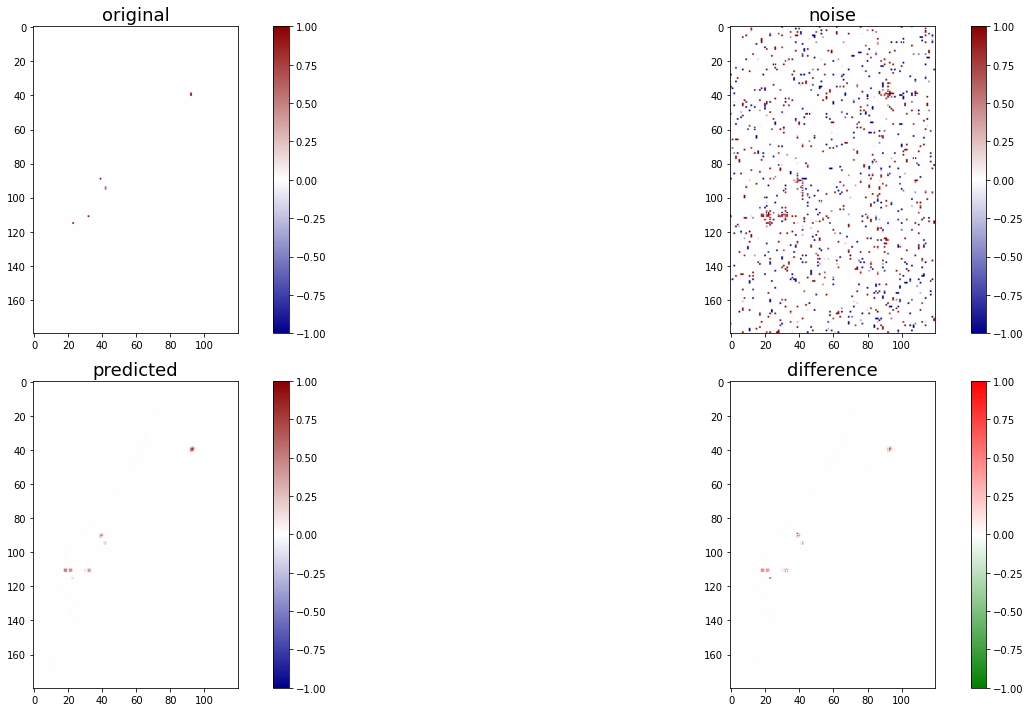

<Figure size 1440x720 with 0 Axes>

In [11]:
test(match_hist_baseline_test )



100%|██████████| 33/33 [00:01<00:00, 20.23it/s]


test loader size: 65
loss of model: cdan_e is 9293.9931640625


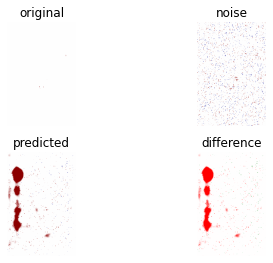

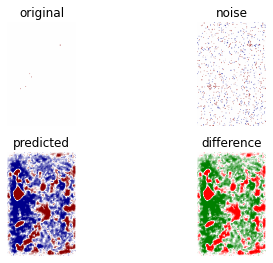

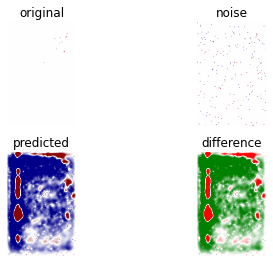

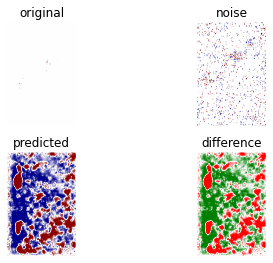

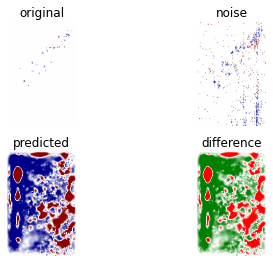

<Figure size 432x288 with 0 Axes>

In [78]:
test(cdan_e_test)


load from:  /root/autoencoder_denoiser/exps/results_4.13_solved_iterator_bug/baseline/latest_model.pt
model :UNet


100%|██████████| 33/33 [00:01<00:00, 26.58it/s]


test loader size: 65
loss of model: baseline is 146.54360961914062


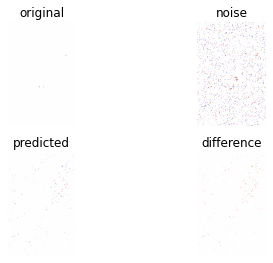

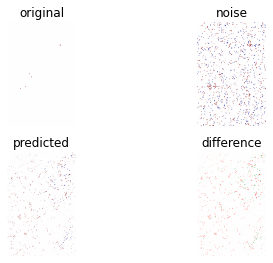

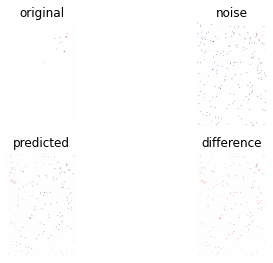

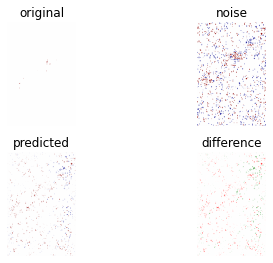

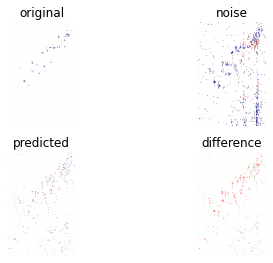

<Figure size 432x288 with 0 Axes>

In [79]:
baseline_test = Test('baseline', config_path='/root/autoencoder_denoiser/configs_4.13_solved_iterator_bug',
                     exp_dir='/root/autoencoder_denoiser/exps/results_4.13_solved_iterator_bug')
test(baseline_test)

In [ ]:
# my_model_test = Test("t1_03")
baseline_test = Test('paper_1d', config_path='/root/autoencoder_denoiser/configs',
                     exp_dir='/root/autoencoder_denoiser/exps/results_4.13_solved_iterator_bug')
test(baseline_test)
# paper_1d_test = Test("paper_1d")

model :UNet
model: Unet config as the paper indicated)


In [ ]:
# def loop_iterable(iterable):
#     while True:
#         yield from iterable
# a=  (loop_iterable([1,2,3,4,5]))


In [ ]:
# a = zip([1,2],3,4,5,6])

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (1649538742.py, line 1)

In [ ]:
# next(a)

2

In [ ]:
# import json, torch
# f = open('/root/autoencoder_denoiser/configs/'+ 't1_03' + '.json')
# config = json.load(f)

# state_dict = torch.load('/root/autoencoder_denoiser/results_new_SNR/t1_03/latest_model.pt')
# model = get_model(config)
# model = torch.nn.DataParallel(model)
# model.load_state_dict(state_dict['model'])

# torch.save(model.module.state_dict(), '/root/autoencoder_denoiser/results_new_SNR/t1_03/latest_model_weight.pt') 

model :UNet


In [ ]:
def tt(*nums):
    for n in nums:
        print(n**2)
        
tt(12,23)

144
529
